In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [21]:
## DEFAULTS

# All times are in ms.

# Conductance of soma
g_l = 0.1
g_d = 2

# Dendritic learning
eta = 0.02
tau_delta = 100

# Synaptic weights
mu = 0.2
w_mean = 0
w_std = 2*mu

# Sigmoidal fxn 
psi_max = 0.15
k = 0.5
beta = 5
vc = 1
sigmoidal = lambda x : psi_max / (1 + k * tf.exp(beta * (vc - x)))
grad_log_sigmoidal = lambda x : beta / (1 + 1/k * tf.exp(beta * (x - vc)))

# Noise fxn
noise_std = 0.2

# Define somatic current input
E_e = 4.667
E_i = -1/3
g_e_ref = 1.0
g_i_ref = 2.0

# Fraction of recurrent connections
recurrent_conn_fraction = 0.5

In [22]:
class neuron_layer():
    
    def __init__(self,layer_size,layer_dendritic_input=None,name = None,nudging_input = None,
                 w_mean = w_mean, w_std = w_std, g_d = g_d, g_l = g_l, E_e = E_e, E_i = E_i, eta = eta,
                 non_linearity = sigmoidal, noise_std = noise_std,
                 recurrent_connections=False, recurrent_conn_fraction = recurrent_conn_fraction,
                 rate_fxn = grad_log_sigmoidal,low_pass_learning = True, tau_delta = tau_delta, record_Vw = False):
        """
        Args:
            nudging_input : tuple of (g_e,g_i), default is None
        """
        self._parse_name(name)
        
        self._parse_layer_input(layer_dendritic_input)
        
        self.layer_size = layer_size
        
        self.nudging_input = nudging_input
        
        self.init_w_mean = w_mean
        self.init_w_std = w_std
        
        self.recurrent_connections = recurrent_connections
        self.recurrent_conn_fraction = recurrent_conn_fraction
        
        self.g_d = g_d
        self.g_l = g_l
        self.dend_factor = (self.g_d)/(self.g_l + self.g_d)
        self.E_e = E_e
        self.E_i = E_i
        self.eta = eta
        
        self.non_linearity = non_linearity
        self.rate_fxn = rate_fxn
        
        self.low_pass_learning = low_pass_learning
        self.tau_delta = tau_delta
        
        self.noise_std = noise_std
        self.somatic_noise = lambda : tf.random_normal((self.layer_size,1),stddev = self.noise_std) # Has to be a function
        
        self.record_Vw = record_Vw
        
        self.construct_layer()
    
    def __str__(self):
        return "Neural layer {0}, dim = {1}".format(self.name,self.layer_size)
    
    def _parse_name(self,name):
        if name == None:
            ind = 1
            while True:
                if not [var for var in tf.global_variables() if 'layer_{0}/U'.format(ind) in var.name]:
                    break
                else:
                    ind +=1
                
            self.name = 'layer_{0}'.format(ind)
        else:
            self.name = name
    
    def _parse_layer_input(self,layer_input):
        if not layer_input:
            self.inputs = None
            self.previous_layer = None
        elif isinstance(layer_input, neuron_layer):
            self.previous_layer = neuron_layer
            self.inputs = neuron_layer.activations # Fxn!
        else:
            self.previous_layer = None
            self.inputs = layer_input # Note that need to make sure that this variable is updated in loop
            
    def construct_layer(self):
        with tf.variable_scope(self.name,reuse=tf.AUTO_REUSE): 
            # Initialize variables
            self.U = tf.get_variable('U', initializer=tf.constant(np.zeros((self.layer_size,1)),dtype=tf.float32))
            self.activations = lambda : tf.identity(self.non_linearity(self.U),name='activations') # Has to be a function so that works in loop
            
            if self.record_Vw:
                self.Vw = tf.get_variable('Vw', initializer=tf.constant(np.zeros((self.layer_size,1)),dtype=tf.float32))
            
            if self.inputs:
                inputs = self.inputs() if callable(self.inputs) else self.inputs
                self.W = tf.get_variable('W', shape=((self.layer_size,inputs.get_shape().as_list()[0])), initializer=tf.random_normal_initializer(mean = self.init_w_mean, stddev = self.init_w_std))
                if self.low_pass_learning:
                    self.delta_W = tf.get_variable('delta_W', initializer=tf.constant(np.zeros(self.W.get_shape().as_list()),dtype=tf.float32))
            
            if self.recurrent_connections:
                self.conn_mask = (np.random.rand(self.layer_size,self.layer_size) <= self.recurrent_conn_fraction)
                init_weights =  self.conn_mask * (self.init_w_std * np.random.randn(self.layer_size,self.layer_size) + self.init_w_mean)
                np.fill_diagonal(init_weights,0.0)
                
                self.W_r = tf.get_variable('W_r', initializer=tf.constant(init_weights,dtype=tf.float32))
                
                if self.low_pass_learning:
                    self.delta_W_r = tf.get_variable('delta_W_r', initializer=tf.constant(np.zeros(self.W_r.get_shape().as_list()),dtype=tf.float32))
                                                         
    def define_updates(self,dt):
        
        activations = self.activations()
        
        if self.inputs:
            inputs = self.inputs() if callable(self.inputs) else self.inputs
            if inputs.shape.ndims == 1:
                inputs = tf.expand_dims(inputs,-1)
            Vw = tf.matmul(self.W,inputs)
        else:
            Vw = tf.constant(np.zeros((self.layer_size,1)),dtype=tf.float32)
            
        if self.recurrent_connections:
            Vw += tf.matmul(self.W_r,activations)
            
        # Euler's method updates
        U_ = self.U * (1 - dt*(self.g_l + self.g_d)) + dt * (self.g_d * Vw + self.somatic_noise())

        if self.nudging_input:
            nudging_input_e = self.nudging_input[0]() if callable(self.nudging_input[0]) else self.nudging_input[0]
            nudging_input_i = self.nudging_input[1]() if callable(self.nudging_input[1]) else self.nudging_input[1]
            if nudging_input_e.shape.ndims == 1:
                nudging_input_e = tf.expand_dims(nudging_input_e,-1)
            if nudging_input_i.shape.ndims == 1:
                nudging_input_i = tf.expand_dims(nudging_input_i,-1)
            U_ += dt*(nudging_input_e * (self.E_e - self.U) + nudging_input_i * (self.E_i - self.U))

        Vw_star = self.dend_factor * Vw
        dend_activation =  self.non_linearity(Vw_star)
        rate_fxn = self.rate_fxn(Vw_star)
        
        if self.inputs:
            PI = tf.matmul((activations - dend_activation)*rate_fxn, tf.transpose(inputs))
            if self.low_pass_learning:
                delta_W_ = self.delta_W * (1-dt/tau_delta) + (dt/tau_delta) * PI
                W_ = self.W + self.eta * dt * delta_W_
            else:
                W_ = self.W + self.eta * dt * PI

        if self.recurrent_connections:
            PI_r = tf.matmul((activations - dend_activation)*rate_fxn, tf.transpose(activations)) * self.conn_mask
            PI_r = tf.linalg.set_diag(PI_r,tf.constant(np.zeros((self.layer_size,)),dtype=tf.float32)) # No self connections
            if self.low_pass_learning:
                delta_W_r_ = self.delta_W_r * (1-dt/tau_delta) + (dt/tau_delta) * PI_r
                W_r_ = self.W_r + self.eta * dt * delta_W_r_
            else:
                W_r_ = self.W_r + self.eta * dt * PI_r
                
        # Operation to update at each time step
        updates = [self.U.assign(U_)]
        if self.inputs:
            updates += [self.W.assign(W_)]
            if self.low_pass_learning:
                updates += [self.delta_W.assign(delta_W_)]
        if self.recurrent_connections:
            updates += [self.W_r.assign(W_r_)]
            if self.low_pass_learning:
                updates += [self.delta_W_r.assign(delta_W_r_)]
        if self.record_Vw:
            updates += [self.Vw.assign(Vw)]
        
        return tf.group(*updates)
    
    def _get_recurrent_updates(self,dt):
        return [self.define_updates(dt)] + (self.previous_layer._get_recurrent_updates(dt) if self.previous_layer else [])
        
    def get_updates(self,dt,recurrent = True):
        if not(recurrent):
            return self.define_updates(dt)
        else:
            return tf.group(*self._get_recurrent_updates(dt))
            
# We want to define a while loop to efficiently run our computation
def gen_loop_body(neural_layer,input_updates,meas_dict,dt):
    def loop_body(ctr):
        # All updates have to live in here!
        variable_updates = input_updates(ctr)
        with tf.control_dependencies([variable_updates]):
            internal_updates = neural_layer.get_updates(dt)
        with tf.control_dependencies([internal_updates]):
            measurements = tf.group([store[ctr].assign(val) for val,store in meas_dict.items()])
        with tf.control_dependencies([measurements]):
            return ctr + 1
    return loop_body

def create_loop_op(n_steps,dt,neural_layer, input_updates = lambda ctr : [], meas_vars = []):
    meas_dict = {key : tf.Variable(np.zeros([n_steps] + key.get_shape().as_list()),dtype=tf.identity(key).dtype) for key in meas_vars}
    tf.variables_initializer(list(meas_dict.values())).run()
    return tf.while_loop(lambda ctr : ctr < (n_steps-1),gen_loop_body(neural_layer,input_updates,meas_dict,dt),[tf.constant(0)]),meas_dict


In [23]:
tf.reset_default_graph() # THIS IS NECESSARY BEFORE MAKING NEW SESSION TO STOP IT ERRORING!!
try:
    sess
except:
    pass
else:
    sess.close()
    del sess
sess = tf.InteractiveSession()

# Set up simulation
dt = 0.2
time_duration = 50000 # ms
n_steps = int(time_duration/dt)
t = np.arange(0,time_duration,dt)

# Define network
layer_size = 500

# Define pattern inputs
block_duration = 500
pattern_reps = int(time_duration/block_duration)
zero_reps = 1 # Pad with an extra rep at the end

t_p = np.arange(0,block_duration,dt)

def tile_pattern(layer_size,pattern,neurons_pattern):
    return np.concatenate([np.zeros((pattern.shape[0],neurons_pattern[0])),
                           np.tile(pattern[:,None],[1,neurons_pattern[1]-neurons_pattern[0]]),
                           np.zeros((pattern.shape[0],layer_size-neurons_pattern[1]))],axis=1)

g_e_pats = []
g_i_pats = []
neurons_pats = []

g_e_pat = g_e_ref*(0.5*np.cos(np.pi * (2 * t_p/100 + 1))+0.5)
g_i_pat = g_i_ref*np.ones(t_p.shape)
neurons_pat = [0,int(0.2*layer_size)]

g_e_pats.append(g_e_pat)
g_i_pats.append(g_i_pat)
neurons_pats.append(neurons_pat)

g_e_pat = g_e_ref*(0.5*np.cos(np.pi * (2 * t_p/250 + 1))+0.5)
g_i_pat = g_i_ref*np.ones(t_p.shape)
neurons_pat = [int(0.2*layer_size),int(0.4*layer_size)]

g_e_pats.append(g_e_pat)
g_i_pats.append(g_i_pat)
neurons_pats.append(neurons_pat)

# Add zero pattern at end 
g_e_pats.append(np.zeros((t_p.shape)))
g_i_pats.append(np.zeros((t_p.shape)))
neurons_pats.append([0,0])

pattern_int = np.concatenate((np.random.randint(len(g_e_pats)-1,size=[pattern_reps]),[-1]*zero_reps),axis=0)

g_e = np.concatenate(np.array([tile_pattern(layer_size,g_e_pat,neurons_pat) for g_e_pat,neurons_pat in zip(g_e_pats,neurons_pats)])[pattern_int],axis=0)
g_i = np.concatenate(np.array([tile_pattern(layer_size,g_i_pat,neurons_pat) for g_i_pat,neurons_pat in zip(g_i_pats,neurons_pats)])[pattern_int],axis=0)
g_e_t = tf.constant(g_e,dtype=tf.float32)
g_i_t = tf.constant(g_i,dtype=tf.float32)

Um_ref = [np.concatenate([(g_e_pats[i] * E_e + g_i_pats[i] * E_i)/(g_e_pats[i] + g_i_pats[i] + 1e-8) if p == i else np.zeros(t_p.shape) for p in pattern_int],axis=0)[:len(t)] for i in [0,1]]

# Variables to hold inputs during computation
nudging_g_e = tf.get_variable('nudging_g_e', initializer=tf.constant(np.zeros((layer_size,)),dtype=tf.float32))
nudging_g_i = tf.get_variable('nudging_g_i', initializer=tf.constant(np.zeros((layer_size,)),dtype=tf.float32))

neurons = neuron_layer(layer_size,nudging_input = (nudging_g_e,nudging_g_i),recurrent_connections=True,low_pass_learning=False,record_Vw=True)

tf.global_variables_initializer().run() # Reset all variables

In [24]:
# Set up run

# Variables to store
meas_vars = [neurons.U,neurons.Vw]

# Input updates 
input_updates = lambda ctr : tf.group(*[nudging_g_e.assign(g_e_t[ctr]),nudging_g_i.assign(g_i_t[ctr])])

loop_op,meas_dict = create_loop_op(n_steps,dt,neurons,input_updates,meas_vars)

# Run
st = time.time()
i = sess.run(loop_op)
print('Run time {0}'.format(time.time() - st))

# Pull out the data
results_dict = {key.name : np.squeeze(np.array(item.eval())) for key,item in meas_dict.items()}


Run time 145.31556296348572


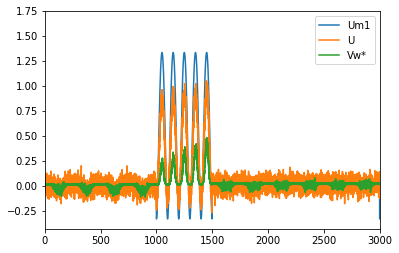

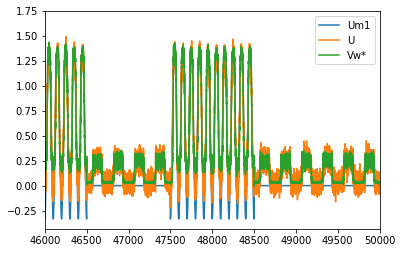

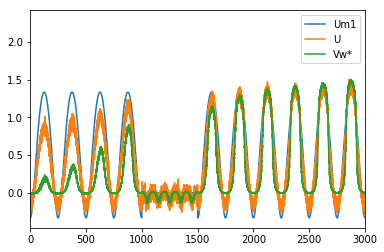

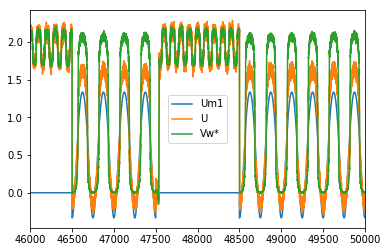

In [25]:
plt.figure()
plt.plot(t,Um_ref[0],label='Um1')
plt.plot(t,results_dict[neurons.U.name][:,0],label='U')
plt.plot(t,(g_d)/(g_l + g_d)*results_dict[neurons.Vw.name][:,0],label='Vw*')
plt.xlim([0,3000])
plt.legend()
plt.show()

plt.figure()
plt.plot(t,Um_ref[0],label='Um1')
plt.plot(t,results_dict[neurons.U.name][:,0],label='U')
plt.plot(t,(g_d)/(g_l + g_d)*results_dict[neurons.Vw.name][:,0],label='Vw*')
plt.xlim([46000,50000])
plt.legend()
plt.show()

plt.figure()
plt.plot(t,Um_ref[1],label='Um1')
plt.plot(t,results_dict[neurons.U.name][:,101],label='U')
plt.plot(t,(g_d)/(g_l + g_d)*results_dict[neurons.Vw.name][:,101],label='Vw*')
plt.xlim([0,3000])
plt.legend()
plt.show()

plt.figure()
plt.plot(t,Um_ref[1],label='Um1')
plt.plot(t,results_dict[neurons.U.name][:,101],label='U')
plt.plot(t,(g_d)/(g_l + g_d)*results_dict[neurons.Vw.name][:,101],label='Vw*')
plt.xlim([46000,50000])
plt.legend()
plt.show()    

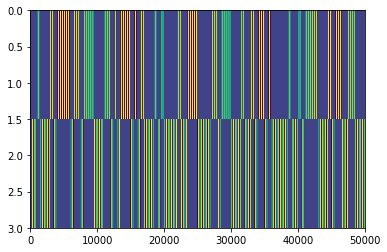

In [26]:
plt.imshow(Um_ref,aspect='auto', extent=[0,t[-1],len(g_e_pats),0])
plt.show()

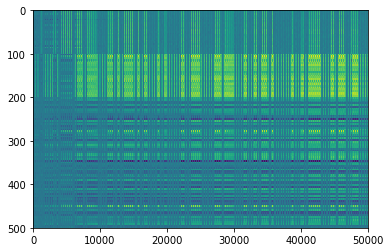

In [27]:
plt.figure()
plt.imshow(results_dict[neurons.U.name][:,0::4].T,aspect='auto', extent=[0,t[-1],layer_size,0])

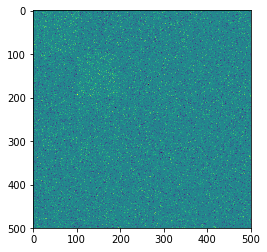

In [28]:
plt.imshow(neurons.W_r.eval())

In [29]:
pattern_int = [0] + [-1]*10 + [1] + [-1]*10
time_duration = block_duration * len(pattern_int)
n_steps = int(time_duration/dt)
t = np.arange(0,time_duration,dt)

g_e = np.concatenate(np.array([tile_pattern(layer_size,g_e_pat,neurons_pat) for g_e_pat,neurons_pat in zip(g_e_pats,neurons_pats)])[pattern_int],axis=0)
g_i = np.concatenate(np.array([tile_pattern(layer_size,g_i_pat,neurons_pat) for g_i_pat,neurons_pat in zip(g_i_pats,neurons_pats)])[pattern_int],axis=0)
g_e_t = tf.constant(g_e,dtype=tf.float32)
g_i_t = tf.constant(g_i,dtype=tf.float32)

Um_ref = [np.concatenate([(g_e_pats[i] * E_e + g_i_pats[i] * E_i)/(g_e_pats[i] + g_i_pats[i] + 1e-8) if p == i else np.zeros(t_p.shape) for p in pattern_int],axis=0) for i in [0,1]]

# Input updates 
input_updates = lambda ctr : tf.group(*[nudging_g_e.assign(g_e_t[ctr]),nudging_g_i.assign(g_i_t[ctr])])
loop_op,meas_dict = create_loop_op(n_steps,dt,neurons,input_updates,meas_vars)

# Run
st = time.time()
i = sess.run(loop_op)
print('Run time {0}'.format(time.time() - st))

# Pull out the data
results_dict = {key.name : np.squeeze(np.array(item.eval())) for key,item in meas_dict.items()}


Run time 41.08771729469299


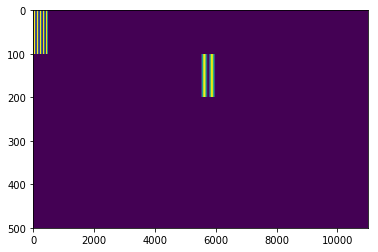

In [30]:
plt.imshow(g_e.T,aspect='auto', extent=[0,t[-1],layer_size,0])
plt.show()

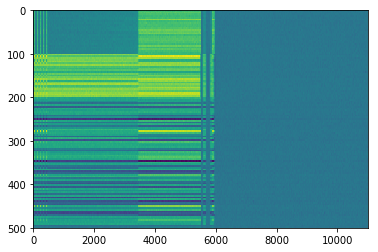

In [31]:
plt.figure()
plt.imshow(results_dict[neurons.U.name][:,0::4].T,aspect='auto', extent=[0,t[-1],layer_size,0])